In [96]:
!pip install gstools
!pip install scikit-learn
!pip install eli5


   -------------------- ------------------- 1/2 [eli5]
   ---------------------------------------- 2/2 [eli5]



Taux de ETR=1 (données originales) : 37.34 %

Contribution des contraintes à ETR=1 :
 - Contrainte V1/V3 seule : 64.09 %
 - Contrainte V6/V8 seule : 32.27 %
 - Contrainte V11/V12 seule : 16.04 %
 - Contrainte V9/V5/V4 seule : 4.71 %

--- Rapport Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6266
           1       1.00      1.00      1.00      3734

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

--- Importance des variables ---
V1 : 0.2669
V3 : 0.2498
V6 : 0.1358
V8 : 0.1109
V12 : 0.0696
V11 : 0.0573
V5 : 0.0251
V4 : 0.0213
V9 : 0.0206
V10 : 0.0146
V7 : 0.0141
V2 : 0.0139


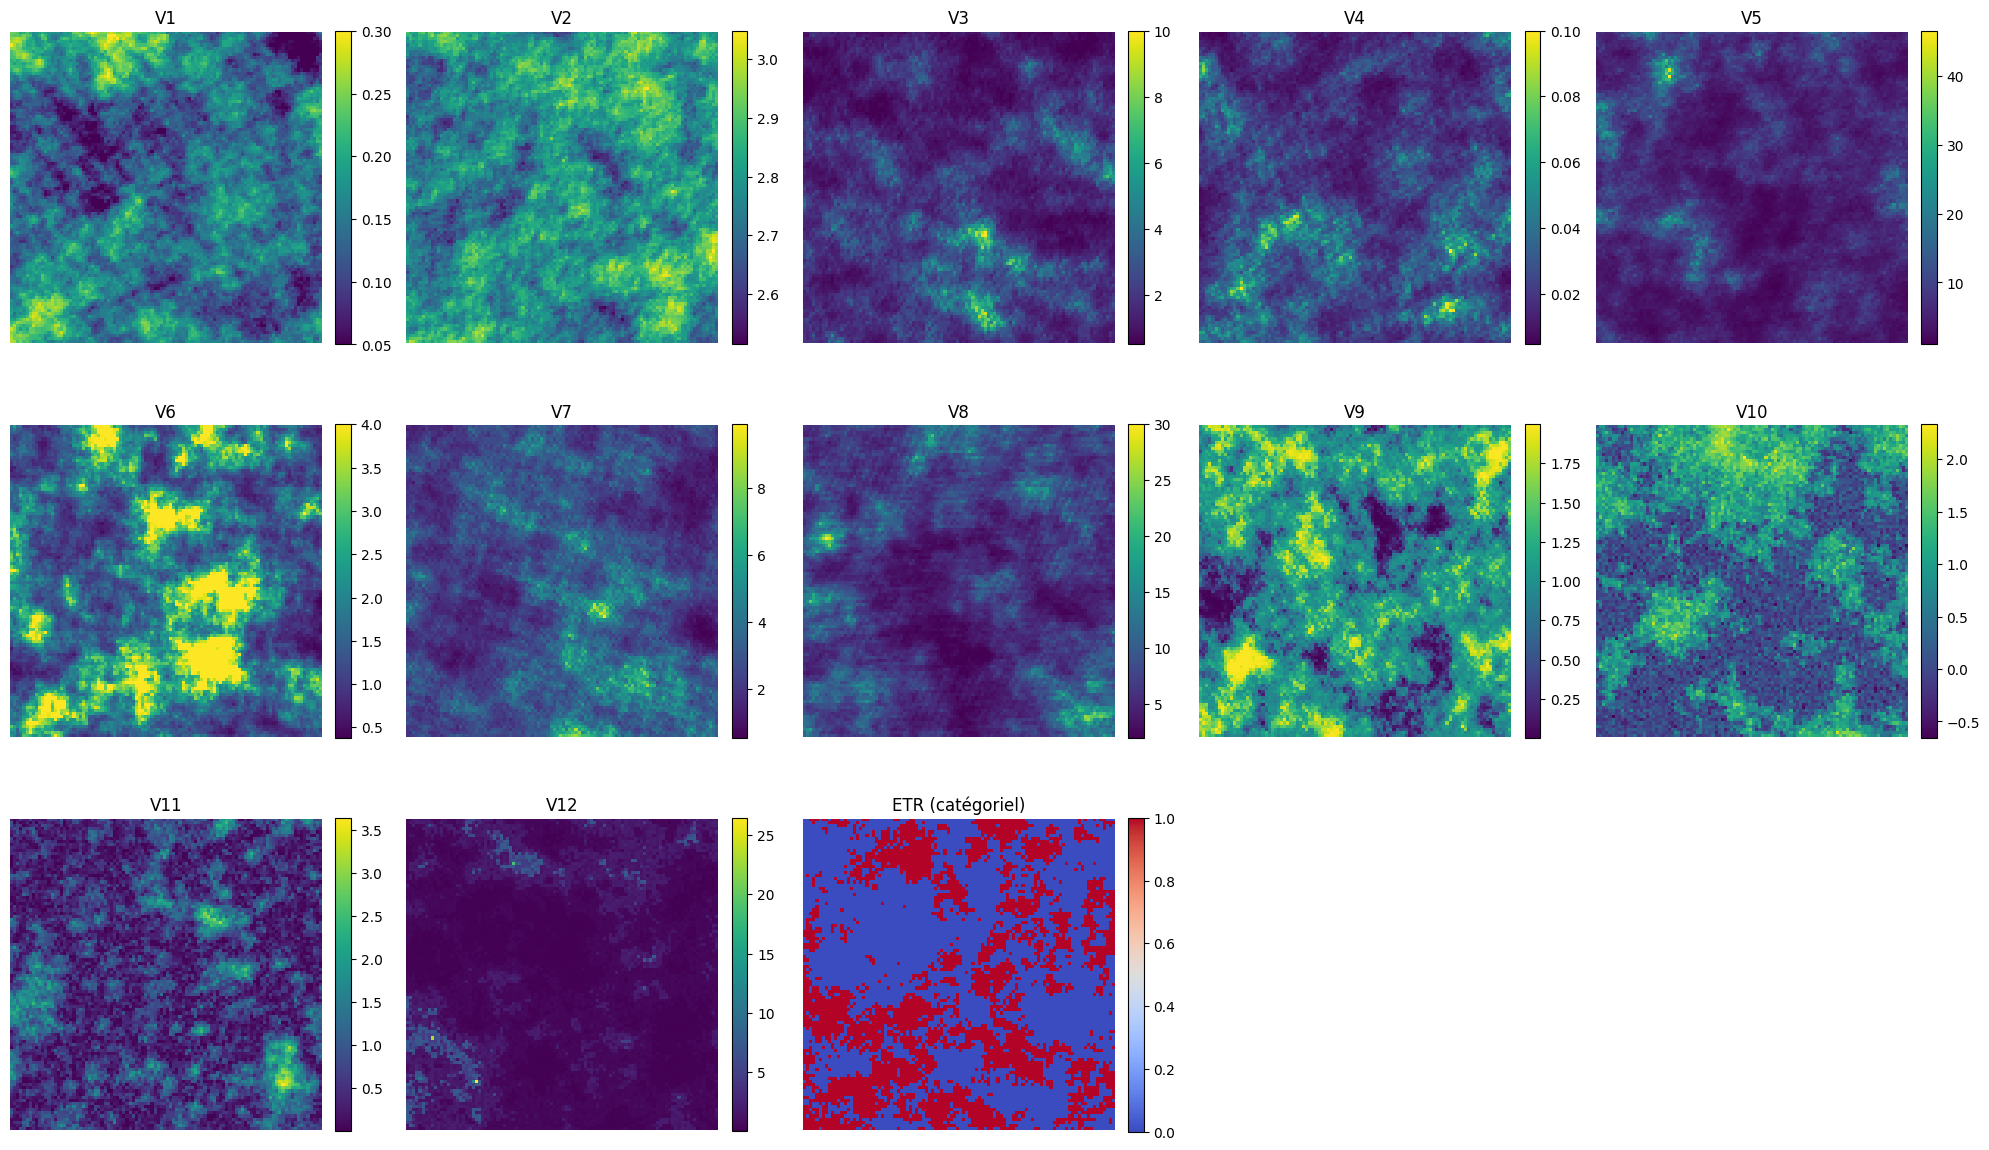

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gstools as gs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# --- 1. Grille et modèle ---
n = 100
x = y = np.linspace(0, 100, n)
coords = np.column_stack(np.meshgrid(x, y)).reshape(-1, 2)
model = gs.Exponential(dim=2, var=1.0, len_scale=10)

# --- 2. Corrélation ---
R_main = np.array([
    [1.00, -0.80, 0.45, -0.10, 0.05, 0.10, -0.05, 0.00],
    [-0.80, 1.00, -0.35, 0.25, -0.10, 0.20, 0.00, -0.05],
    [0.45, -0.35, 1.00, 0.40, -0.25, 0.15, 0.10, 0.05],
    [-0.10, 0.25, 0.40, 1.00, 0.55, -0.20, 0.25, 0.15],
    [0.05, -0.10, -0.25, 0.55, 1.00, 0.75, -0.30, 0.40],
    [0.10, 0.20, 0.15, -0.20, 0.75, 1.00, 0.85, -0.50],
    [-0.05, 0.00, 0.10, 0.25, -0.30, 0.85, 1.00, 0.60],
    [0.00, -0.05, 0.05, 0.15, 0.40, -0.50, 0.60, 1.00]
])

R_parasite = np.array([
    [1.0, 0.5, -0.3, 0.1],
    [0.5, 1.0, 0.4, -0.2],
    [-0.3, 0.4, 1.0, 0.3],
    [0.1, -0.2, 0.3, 1.0]
])

R_full = np.block([
    [R_main,                     np.zeros((8, 4))],
    [np.zeros((4, 8)), R_parasite]
])

def nearest_pos_def(A):
    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)
    H = np.dot(V.T * s, V)
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not np.all(np.linalg.eigvals(A3) > 0):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1
    return A3

R_full = nearest_pos_def(R_full)
L_full = np.linalg.cholesky(R_full)

# --- 3. Simulation ---
Z_raw = []
for i in range(12):
    srf = gs.SRF(model, seed=42 + i)
    Z_raw.append(srf((x, y), mesh_type="structured").ravel())
Z_raw = np.vstack(Z_raw)

# --- 4. Construction du DataFrame avec noms d'origine ---

def bimodal_transform(z):
    # somme de 2 sigmoïdes centrées différemment
    return 1/(1 + np.exp(-3*(z - 1))) + 1/(1 + np.exp(-3*(z + 1)))

def heavy_tail_transform(z):
    # transformer la partie positive avec une puissance < 1 (queue lourde)
    z_pos = np.clip(z, 0, None)
    return np.sign(z) * (np.abs(z_pos)**0.5 + 0.2 * np.random.randn(*z.shape))

def u_shape_transform(z):
    # fonction en U : distance au centre
    return np.abs(z)

def asymmetric_transform(z):
    # exponentielle décalée + sinus
    return np.exp(z) * (1 + 0.5 * np.sin(5*z))
    
df = pd.DataFrame({
    'x': coords[:, 0],
    'y': coords[:, 1],
    'V1': np.clip(0.15 + 0.05 * Z_raw[0], 0.05, 0.3),
    'V2': np.clip(2.75 + 0.1 * Z_raw[1], 2.5, 3.2),
    'V3': np.clip(np.exp(0.5 + 0.5 * Z_raw[2]), 0.5, 10),
    'V4': np.clip(np.exp(-4 + 0.5 * Z_raw[3]), 1e-4, 0.1),
    'V5': np.clip(np.exp(2 + 0.5 * Z_raw[4]), 1, 50),
    'V6': np.clip(np.exp(0.4 + 0.5 * Z_raw[5]), 0.1, 4),
    'V7': np.clip(np.exp(1.0 + 0.4 * Z_raw[6]), 0.5, 10),
    'V8': np.clip(np.exp(2.0 + 0.4 * Z_raw[7]), 2, 30),
    'V9': bimodal_transform(Z_raw[8]),
    'V10': heavy_tail_transform(Z_raw[9]),
    'V11': u_shape_transform(Z_raw[10]),
    'V12': asymmetric_transform(Z_raw[11]),
})

# --- 5. Calcul de la classe ETR ---
target_rate = 0.30  # objectif global environ

# Définition des clusters avec variables
cluster_vars = {
    "Très importantes": ['V1', 'V3'],
    "Importantes": ['V6', 'V8'],
    "Faibles": ['V11', 'V12'],
    "Faiblement informatives": ['V9', 'V5', 'V4']
}

# Définition des seuils quantiles selon cluster
quantiles = {
    "Très importantes": 0.50,   # seuil facile (on prend 60% supérieurs)
    "Importantes": 0.65,         # un peu plus dur
    "Faibles": 0.75,             # plus strict
}

thresh = {}
for cluster, vars_list in cluster_vars.items():
    if cluster != "Faiblement informatives":
        q = quantiles[cluster]
        for v in vars_list:
            thresh[v] = df[v].quantile(q)
thresh['V9'] = df['V9'].quantile(0.75)
thresh['V5'] = df['V5'].quantile(0.80)
thresh['V4'] = df['V4'].quantile(0.35)

cond1 = ((df['V1'] > thresh['V1']) & (df['V3'] > thresh['V3']))
cond2 = ((df['V6'] > thresh['V6']) & (df['V8'] > thresh['V8']))
cond3 = ((df['V11'] > thresh['V11']) & (df['V12'] > thresh['V12']))
cond4 = ((df['V9'] > thresh['V9']) & (df['V5'] > thresh['V5']) & (df['V4'] < thresh['V4']))

df['ETR'] = (cond1 | cond2 | cond3 | cond4).astype(int)

# Contribution de chaque contrainte à ETR=1
n_total = df['ETR'].sum()
contrib1 = (cond1.sum()) / n_total * 100
contrib2 = (cond2 .sum()) / n_total * 100
contrib3 = (cond3.sum()) / n_total * 100
contrib4 = (cond4 .sum()) / n_total * 100

print(f"Taux de ETR=1 (données originales) : {df['ETR'].mean() * 100:.2f} %")
print(f"\nContribution des contraintes à ETR=1 :")
print(f" - Contrainte V1/V3 seule : {contrib1:.2f} %")
print(f" - Contrainte V6/V8 seule : {contrib2:.2f} %")
print(f" - Contrainte V11/V12 seule : {contrib3:.2f} %")
print(f" - Contrainte V9/V5/V4 seule : {contrib4:.2f} %")


# --- 6. Analyse ---
def run_analysis(df_input):
    features = [f"V{i}" for i in range(1, 13)]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_input[features])

    pca = PCA(n_components=2)
    pca.fit(X_scaled)

    kmeans = KMeans(n_clusters=2, random_state=0)
    kmeans.fit(X_scaled)

    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(X_scaled, df_input['ETR'])

    print("\n--- Rapport Random Forest ---")
    print(classification_report(df_input['ETR'], clf.predict(X_scaled), zero_division=0))

    print("--- Importance des variables ---")
    for i, f in enumerate(np.argsort(clf.feature_importances_)[::-1]):
        print(f"{features[f]} : {clf.feature_importances_[f]:.4f}")

run_analysis(df)

# --- 7. Visualisation ---
nx = ny = 100
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 5, figsize=(20, 12))
axs = axs.flatten()

for i, var in enumerate([f"V{i}" for i in range(1, 13)]):
    ax = axs[i]
    im = ax.imshow(df[var].values.reshape(ny, nx), origin='lower', cmap='viridis')
    ax.set_title(var)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax = axs[12]
im = ax.imshow(df['ETR'].values.reshape(ny, nx), origin='lower', cmap='coolwarm')
ax.set_title('ETR (catégoriel)')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

for j in [13, 14]:
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


Taux de ETR=1 (données originales) : 37.34 %

Jeu de données bruité créé. La classe 'ETR' reste inchangée.

--- Analyse sur les données originales ---

--- Rapport Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6266
           1       1.00      1.00      1.00      3734

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

--- Importance des variables ---
V1     0.263353
V3     0.252963
V6     0.131462
V8     0.113059
V12    0.073385
V11    0.057200
V5     0.024976
V4     0.021381
V9     0.020055
V7     0.014403
V10    0.014154
V2     0.013610
dtype: float64

--- Analyse sur les données bruitées ---

--- Rapport Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6266
           1       1.00      1.00      1.00      3734

    accuracy  

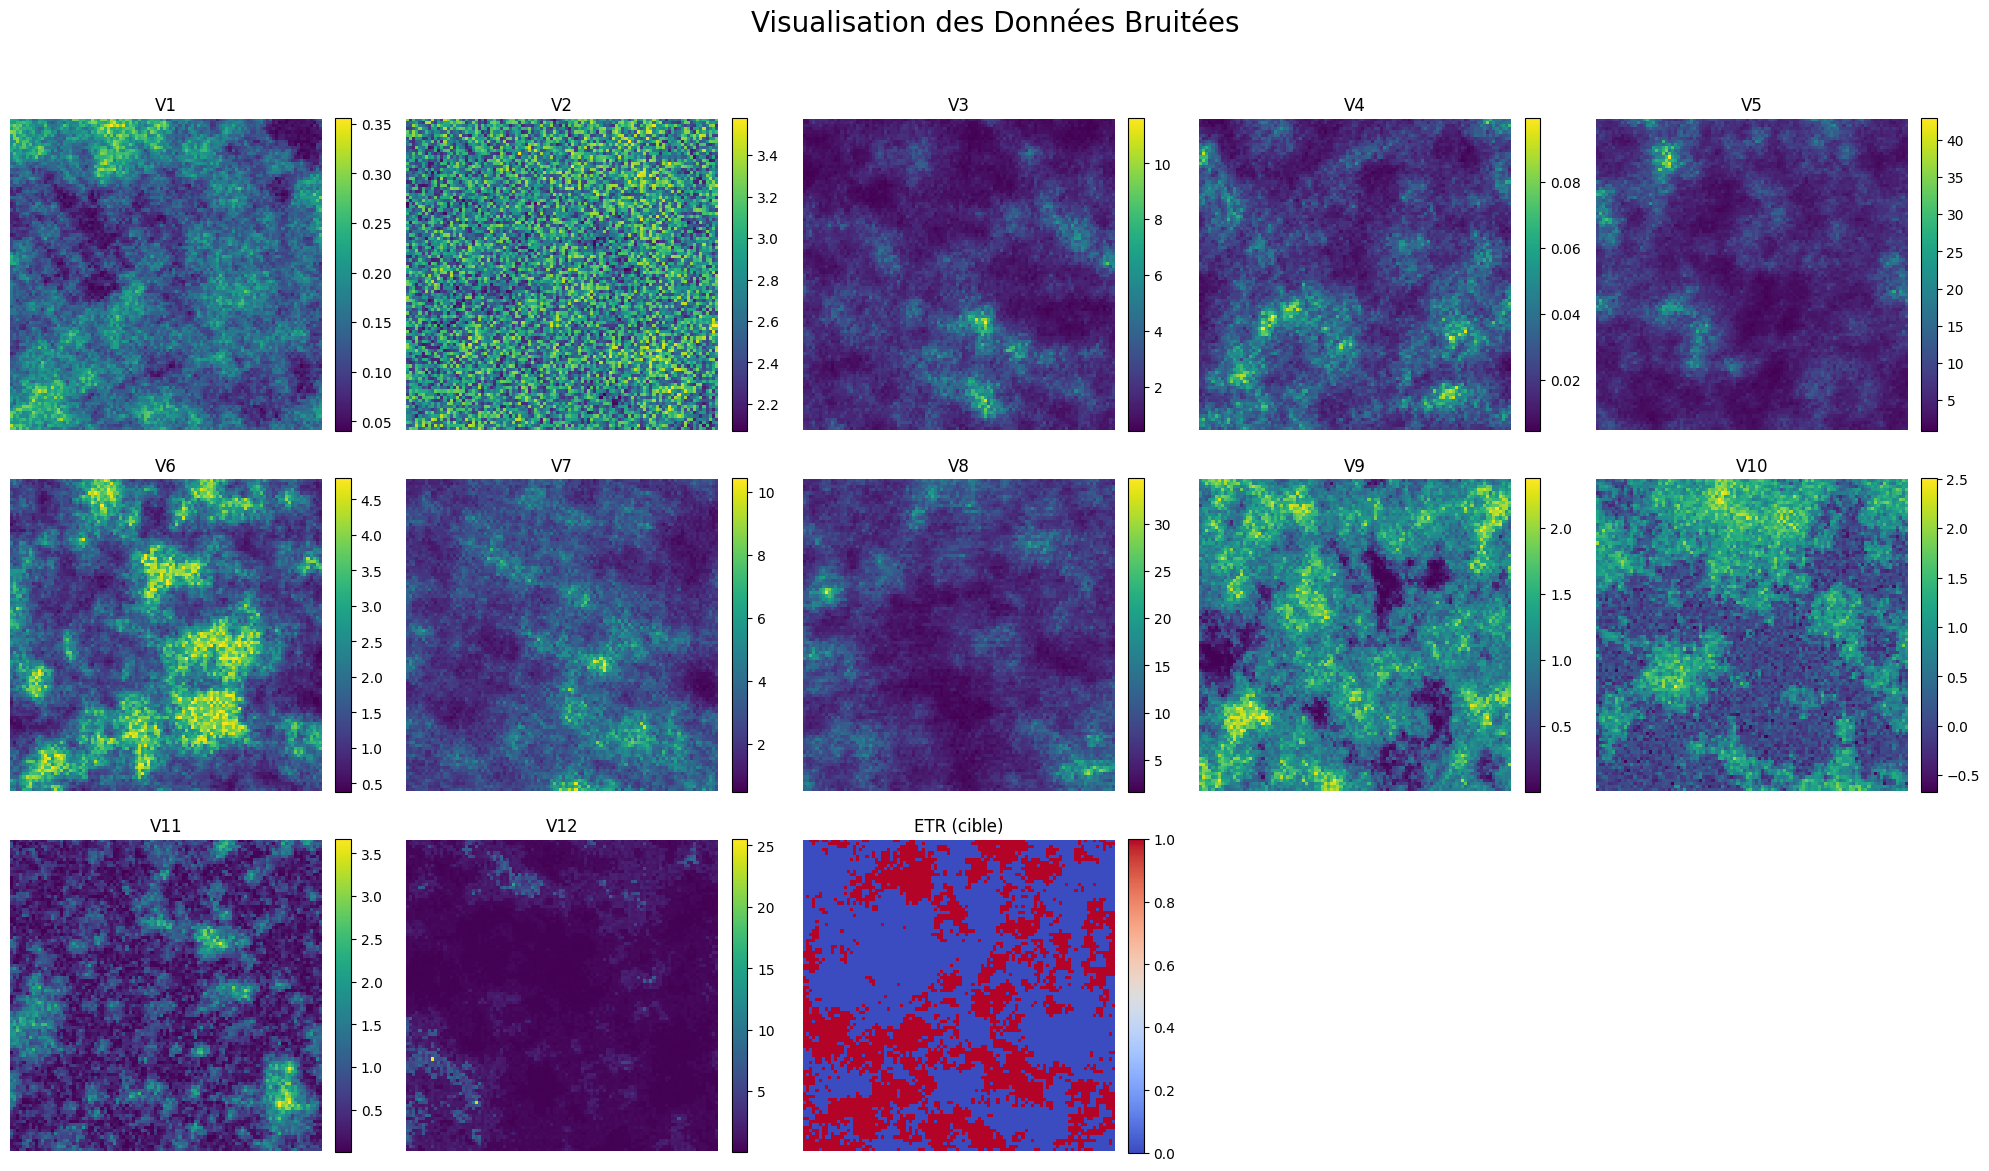

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gstools as gs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# --- 1. Grille et modèle ---
n = 100
x = y = np.linspace(0, 100, n)
coords = np.column_stack(np.meshgrid(x, y)).reshape(-1, 2)
model = gs.Exponential(dim=2, var=1.0, len_scale=10)

# --- 2. Corrélation ---
R_main = np.array([
    [1.00, -0.80, 0.45, -0.10, 0.05, 0.10, -0.05, 0.00],
    [-0.80, 1.00, -0.35, 0.25, -0.10, 0.20, 0.00, -0.05],
    [0.45, -0.35, 1.00, 0.40, -0.25, 0.15, 0.10, 0.05],
    [-0.10, 0.25, 0.40, 1.00, 0.55, -0.20, 0.25, 0.15],
    [0.05, -0.10, -0.25, 0.55, 1.00, 0.75, -0.30, 0.40],
    [0.10, 0.20, 0.15, -0.20, 0.75, 1.00, 0.85, -0.50],
    [-0.05, 0.00, 0.10, 0.25, -0.30, 0.85, 1.00, 0.60],
    [0.00, -0.05, 0.05, 0.15, 0.40, -0.50, 0.60, 1.00]
])

R_parasite = np.array([
    [1.0, 0.5, -0.3, 0.1],
    [0.5, 1.0, 0.4, -0.2],
    [-0.3, 0.4, 1.0, 0.3],
    [0.1, -0.2, 0.3, 1.0]
])

R_full = np.block([
    [R_main,               np.zeros((8, 4))],
    [np.zeros((4, 8)), R_parasite]
])

def nearest_pos_def(A):
    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)
    H = np.dot(V.T * s, V)
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not np.all(np.linalg.eigvals(A3) > 0):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1
    return A3

R_full = nearest_pos_def(R_full)
L_full = np.linalg.cholesky(R_full)

# --- 3. Simulation ---
Z_raw = []
for i in range(12):
    srf = gs.SRF(model, seed=42 + i)
    Z_raw.append(srf((x, y), mesh_type="structured").ravel())
Z_raw = np.vstack(Z_raw)

# --- 4. Construction du DataFrame avec noms d'origine ---

def bimodal_transform(z):
    return 1/(1 + np.exp(-3*(z - 1))) + 1/(1 + np.exp(-3*(z + 1)))

def heavy_tail_transform(z):
    z_pos = np.clip(z, 0, None)
    return np.sign(z) * (np.abs(z_pos)**0.5 + 0.2 * np.random.randn(*z.shape))

def u_shape_transform(z):
    return np.abs(z)

def asymmetric_transform(z):
    return np.exp(z) * (1 + 0.5 * np.sin(5*z))
    
df = pd.DataFrame({
    'x': coords[:, 0],
    'y': coords[:, 1],
    'V1': np.clip(0.15 + 0.05 * Z_raw[0], 0.05, 0.3),
    'V2': np.clip(2.75 + 0.1 * Z_raw[1], 2.5, 3.2),
    'V3': np.clip(np.exp(0.5 + 0.5 * Z_raw[2]), 0.5, 10),
    'V4': np.clip(np.exp(-4 + 0.5 * Z_raw[3]), 1e-4, 0.1),
    'V5': np.clip(np.exp(2 + 0.5 * Z_raw[4]), 1, 50),
    'V6': np.clip(np.exp(0.4 + 0.5 * Z_raw[5]), 0.1, 4),
    'V7': np.clip(np.exp(1.0 + 0.4 * Z_raw[6]), 0.5, 10),
    'V8': np.clip(np.exp(2.0 + 0.4 * Z_raw[7]), 2, 30),
    'V9': bimodal_transform(Z_raw[8]),
    'V10': heavy_tail_transform(Z_raw[9]),
    'V11': u_shape_transform(Z_raw[10]),
    'V12': asymmetric_transform(Z_raw[11]),
})

# --- 5. Calcul de la classe ETR ---
target_rate = 0.30

cluster_vars = {
    "Très importantes": ['V1', 'V3'],
    "Importantes": ['V6', 'V8'],
    "Faibles": ['V11', 'V12'],
    "Faiblement informatives": ['V9', 'V5', 'V4']
}

quantiles = {
    "Très importantes": 0.50,
    "Importantes": 0.65,
    "Faibles": 0.75,
}

thresh = {}

for cluster, vars_list in cluster_vars.items():
    if cluster != "Faiblement informatives":
        q = quantiles[cluster]
        for v in vars_list:
            thresh[v] = df[v].quantile(q)

thresh['V9'] = df['V9'].quantile(0.75)
thresh['V5'] = df['V5'].quantile(0.80)
thresh['V4'] = df['V4'].quantile(0.35)

df['ETR'] = (
    ((df['V1'] > thresh['V1']) & (df['V3'] > thresh['V3'])) |
    ((df['V6'] > thresh['V6']) & (df['V8'] > thresh['V8'])) |
    ((df['V11'] > thresh['V11']) & (df['V12'] > thresh['V12'])) |
    ((df['V9'] > thresh['V9']) & (df['V5'] > thresh['V5']) & (df['V4'] < thresh['V4']))
).astype(int)

print(f"Taux de ETR=1 (données originales) : {df['ETR'].mean() * 100:.2f} %")

# --- NOUVELLE ÉTAPE : Création du jeu de données bruité ---

# Copier le DataFrame original pour y ajouter le bruit
df_noisy = df.copy()

# Variables auxquelles ajouter du bruit
features_to_noise = [f"V{i}" for i in range(1, 13)]

# Boucle pour ajouter le bruit à chaque variable
for var in features_to_noise:
    # Générer un bruit aléatoire entre -10% et +10% de la valeur de chaque point
    noise = np.random.uniform(-0.20, 0.20, df_noisy[var].shape) * df_noisy[var]
    df_noisy[var] = df_noisy[var] + noise

print("\nJeu de données bruité créé. La classe 'ETR' reste inchangée.")

# Sauvegarde CSV ---

cols_to_save = ['x', 'y'] + [f"V{i}" for i in range(1, 13)] + ['ETR']

df[cols_to_save].to_csv('donnees_reelles.csv', index=False)
df_noisy[cols_to_save].to_csv('donnees_bruits.csv', index=False)

# --- 6. Analyse ---
def run_analysis(df_input, title):
    print(f"\n--- {title} ---")
    features = [f"V{i}" for i in range(1, 13)]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_input[features])

    pca = PCA(n_components=2)
    pca.fit(X_scaled)

    kmeans = KMeans(n_clusters=2, random_state=0)
    kmeans.fit(X_scaled)

    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(X_scaled, df_input['ETR'])

    print("\n--- Rapport Random Forest ---")
    print(classification_report(df_input['ETR'], clf.predict(X_scaled), zero_division=0))

    print("--- Importance des variables ---")
    # Afficher les importances triées
    importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
    print(importances)


# Analyse sur les données originales
run_analysis(df, "Analyse sur les données originales")

# Analyse sur les nouvelles données bruitées
run_analysis(df_noisy, "Analyse sur les données bruitées")


# --- 7. Visualisation des données bruitées ---
nx = ny = 100
fig, axs = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle("Visualisation des Données Bruitées", fontsize=20)
axs = axs.flatten()

for i, var in enumerate(features_to_noise):
    ax = axs[i]
    im = ax.imshow(df_noisy[var].values.reshape(ny, nx), origin='lower', cmap='viridis')
    ax.set_title(var)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Affichage de la classe ETR (qui est la même)
ax = axs[12]
im = ax.imshow(df_noisy['ETR'].values.reshape(ny, nx), origin='lower', cmap='coolwarm')
ax.set_title('ETR (cible)')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Supprimer les axes inutilisés
for j in [13, 14]:
    fig.delaxes(axs[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gstools as gs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# --- 1. Grille et modèle ---
n = 100
x = y = np.linspace(0, 100, n)
coords = np.column_stack(np.meshgrid(x, y)).reshape(-1, 2)
model = gs.Exponential(dim=2, var=1.0, len_scale=10)

# --- 2. Corrélation ---
R_main = np.array([
    [1.00, -0.80, 0.45, -0.10, 0.05, 0.10, -0.05, 0.00],
    [-0.80, 1.00, -0.35, 0.25, -0.10, 0.20, 0.00, -0.05],
    [0.45, -0.35, 1.00, 0.40, -0.25, 0.15, 0.10, 0.05],
    [-0.10, 0.25, 0.40, 1.00, 0.55, -0.20, 0.25, 0.15],
    [0.05, -0.10, -0.25, 0.55, 1.00, 0.75, -0.30, 0.40],
    [0.10, 0.20, 0.15, -0.20, 0.75, 1.00, 0.85, -0.50],
    [-0.05, 0.00, 0.10, 0.25, -0.30, 0.85, 1.00, 0.60],
    [0.00, -0.05, 0.05, 0.15, 0.40, -0.50, 0.60, 1.00]
])

R_parasite = np.array([
    [1.0, 0.5, -0.3, 0.1],
    [0.5, 1.0, 0.4, -0.2],
    [-0.3, 0.4, 1.0, 0.3],
    [0.1, -0.2, 0.3, 1.0]
])

R_full = np.block([
    [R_main,               np.zeros((8, 4))],
    [np.zeros((4, 8)), R_parasite]
])

def nearest_pos_def(A):
    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)
    H = np.dot(V.T * s, V)
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not np.all(np.linalg.eigvals(A3) > 0):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1
    return A3

R_full = nearest_pos_def(R_full)
L_full = np.linalg.cholesky(R_full)

# --- 3. Simulation ---
Z_raw = []
for i in range(12):
    srf = gs.SRF(model, seed=42 + i)
    Z_raw.append(srf((x, y), mesh_type="structured").ravel())
Z_raw = np.vstack(Z_raw)

# --- 4. Construction du DataFrame avec noms d'origine ---
def bimodal_transform(z):
    return 1/(1 + np.exp(-3*(z - 1))) + 1/(1 + np.exp(-3*(z + 1)))

def heavy_tail_transform(z):
    z_pos = np.clip(z, 0, None)
    return np.sign(z) * (np.abs(z_pos)**0.5 + 0.2 * np.random.randn(*z.shape))

def u_shape_transform(z):
    return np.abs(z)

def asymmetric_transform(z):
    return np.exp(z) * (1 + 0.5 * np.sin(5*z))


df = pd.DataFrame({
    'x': coords[:, 0],
    'y': coords[:, 1],
    'V1': np.clip(0.15 + 0.05 * Z_raw[0], 0.05, 0.3),
    'V2': np.clip(2.75 + 0.1 * Z_raw[1], 2.5, 3.2),
    'V3': np.clip(np.exp(0.5 + 0.5 * Z_raw[2]), 0.5, 10),
    'V4': np.clip(np.exp(-4 + 0.5 * Z_raw[3]), 1e-4, 0.1),
    'V5': np.clip(np.exp(2 + 0.5 * Z_raw[4]), 1, 50),
    'V6': np.clip(np.exp(0.4 + 0.5 * Z_raw[5]), 0.1, 4),
    'V7': np.clip(np.exp(1.0 + 0.4 * Z_raw[6]), 0.5, 10),
    'V8': np.clip(np.exp(2.0 + 0.4 * Z_raw[7]), 2, 30),
    'V9': bimodal_transform(Z_raw[8]),
    'V10': heavy_tail_transform(Z_raw[9]),
    'V11': u_shape_transform(Z_raw[10]),
    'V12': asymmetric_transform(Z_raw[11]),
})

# --- 5. Calcul de la classe ETR ---
target_rate = 0.30
cluster_vars = {
    "Très importantes": ['V1', 'V3'],
    "Importantes": ['V6', 'V8'],
    "Faibles": ['V11', 'V12'],
    "Faiblement informatives": ['V9', 'V5', 'V4']
}
quantiles = {
    "Très importantes": 0.50,
    "Importantes": 0.65,
    "Faibles": 0.75,
}
thresh = {}
for cluster, vars_list in cluster_vars.items():
    if cluster != "Faiblement informatives":
        q = quantiles[cluster]
        for v in vars_list:
            thresh[v] = df[v].quantile(q)
thresh['V9'] = df['V9'].quantile(0.75)
thresh['V5'] = df['V5'].quantile(0.80)
thresh['V4'] = df['V4'].quantile(0.35)
df['ETR'] = (
    ((df['V1'] > thresh['V1']) & (df['V3'] > thresh['V3'])) |
    ((df['V6'] > thresh['V6']) & (df['V8'] > thresh['V8'])) |
    ((df['V11'] > thresh['V11']) & (df['V12'] > thresh['V12'])) |
    ((df['V9'] > thresh['V9']) & (df['V5'] > thresh['V5']) & (df['V4'] < thresh['V4']))
).astype(int)
print(f"Taux de ETR=1 (données originales) : {df['ETR'].mean() * 100:.2f} %")

# --- Échantillonnage ---
df_sample = df.sample(n=100, random_state=1)

# --- Création du jeu de données bruité ---
df_noisy = df_sample.copy()
features_to_noise = [f"V{i}" for i in range(1, 13)]
for var in features_to_noise:
    noise = np.random.uniform(-0.20, 0.20, df_noisy[var].shape) * df_noisy[var]
    df_noisy[var] += noise
print("\nJeu de données bruité (échantillon) créé. La classe 'ETR' reste inchangée.")

# --- 6. Analyse ---
def run_analysis(df_input, title):
    print(f"\n--- {title} ---")
    features = [f"V{i}" for i in range(1, 13)]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_input[features])
    pca = PCA(n_components=2)
    pca.fit(X_scaled)
    kmeans = KMeans(n_clusters=2, random_state=0)
    kmeans.fit(X_scaled)
    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(X_scaled, df_input['ETR'])
    print("\n--- Rapport Random Forest ---")
    print(classification_report(df_input['ETR'], clf.predict(X_scaled), zero_division=0))
    print("--- Importance des variables ---")
    importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
    print(importances)

run_analysis(df_sample, "Analyse sur les données originales (échantillon)")
run_analysis(df_noisy, "Analyse sur les données bruitées (échantillon)")

Taux de ETR=1 (données originales) : 37.34 %

Jeu de données bruité (échantillon) créé. La classe 'ETR' reste inchangée.

--- Analyse sur les données originales (échantillon) ---

--- Rapport Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        45

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

--- Importance des variables ---
V1     0.179078
V6     0.122470
V3     0.113706
V8     0.100353
V11    0.090830
V12    0.082605
V2     0.070281
V5     0.051629
V9     0.051289
V7     0.049956
V10    0.046787
V4     0.041015
dtype: float64

--- Analyse sur les données bruitées (échantillon) ---

--- Rapport Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00    

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gstools as gs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# --- 1. Grille et modèle ---
n = 100
x = y = np.linspace(0, 100, n)
coords = np.column_stack(np.meshgrid(x, y)).reshape(-1, 2)
model = gs.Exponential(dim=2, var=1.0, len_scale=10)

# --- 2. Corrélation ---
R_main = np.array([
    [1.00, -0.80, 0.45, -0.10, 0.05, 0.10, -0.05, 0.00],
    [-0.80, 1.00, -0.35, 0.25, -0.10, 0.20, 0.00, -0.05],
    [0.45, -0.35, 1.00, 0.40, -0.25, 0.15, 0.10, 0.05],
    [-0.10, 0.25, 0.40, 1.00, 0.55, -0.20, 0.25, 0.15],
    [0.05, -0.10, -0.25, 0.55, 1.00, 0.75, -0.30, 0.40],
    [0.10, 0.20, 0.15, -0.20, 0.75, 1.00, 0.85, -0.50],
    [-0.05, 0.00, 0.10, 0.25, -0.30, 0.85, 1.00, 0.60],
    [0.00, -0.05, 0.05, 0.15, 0.40, -0.50, 0.60, 1.00]
])

R_parasite = np.array([
    [1.0, 0.5, -0.3, 0.1],
    [0.5, 1.0, 0.4, -0.2],
    [-0.3, 0.4, 1.0, 0.3],
    [0.1, -0.2, 0.3, 1.0]
])

R_full = np.block([
    [R_main,               np.zeros((8, 4))],
    [np.zeros((4, 8)), R_parasite]
])

def nearest_pos_def(A):
    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)
    H = np.dot(V.T * s, V)
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not np.all(np.linalg.eigvals(A3) > 0):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1
    return A3

R_full = nearest_pos_def(R_full)
L_full = np.linalg.cholesky(R_full)

# --- 3. Simulation ---
Z_raw = []
for i in range(12):
    srf = gs.SRF(model, seed=42 + i)
    Z_raw.append(srf((x, y), mesh_type="structured").ravel())
Z_raw = np.vstack(Z_raw)

# --- 4. Construction du DataFrame avec noms d'origine ---
def bimodal_transform(z):
    return 1/(1 + np.exp(-3*(z - 1))) + 1/(1 + np.exp(-3*(z + 1)))

def heavy_tail_transform(z):
    z_pos = np.clip(z, 0, None)
    return np.sign(z) * (np.abs(z_pos)**0.5 + 0.2 * np.random.randn(*z.shape))

def u_shape_transform(z):
    return np.abs(z)

def asymmetric_transform(z):
    return np.exp(z) * (1 + 0.5 * np.sin(5*z))


df = pd.DataFrame({
    'x': coords[:, 0],
    'y': coords[:, 1],
    'V1': np.clip(0.15 + 0.05 * Z_raw[0], 0.05, 0.3),
    'V2': np.clip(2.75 + 0.1 * Z_raw[1], 2.5, 3.2),
    'V3': np.clip(np.exp(0.5 + 0.5 * Z_raw[2]), 0.5, 10),
    'V4': np.clip(np.exp(-4 + 0.5 * Z_raw[3]), 1e-4, 0.1),
    'V5': np.clip(np.exp(2 + 0.5 * Z_raw[4]), 1, 50),
    'V6': np.clip(np.exp(0.4 + 0.5 * Z_raw[5]), 0.1, 4),
    'V7': np.clip(np.exp(1.0 + 0.4 * Z_raw[6]), 0.5, 10),
    'V8': np.clip(np.exp(2.0 + 0.4 * Z_raw[7]), 2, 30),
    'V9': bimodal_transform(Z_raw[8]),
    'V10': heavy_tail_transform(Z_raw[9]),
    'V11': u_shape_transform(Z_raw[10]),
    'V12': asymmetric_transform(Z_raw[11]),
})

# --- 5. Calcul de la classe ETR ---
target_rate = 0.30
cluster_vars = {
    "Très importantes": ['V1', 'V3'],
    "Importantes": ['V6', 'V8'],
    "Faibles": ['V11', 'V12'],
    "Faiblement informatives": ['V9', 'V5', 'V4']
}
quantiles = {
    "Très importantes": 0.50,
    "Importantes": 0.65,
    "Faibles": 0.75,
}
thresh = {}
for cluster, vars_list in cluster_vars.items():
    if cluster != "Faiblement informatives":
        q = quantiles[cluster]
        for v in vars_list:
            thresh[v] = df[v].quantile(q)
thresh['V9'] = df['V9'].quantile(0.75)
thresh['V5'] = df['V5'].quantile(0.80)
thresh['V4'] = df['V4'].quantile(0.35)
df['ETR'] = (
    ((df['V1'] > thresh['V1']) & (df['V3'] > thresh['V3'])) |
    ((df['V6'] > thresh['V6']) & (df['V8'] > thresh['V8'])) |
    ((df['V11'] > thresh['V11']) & (df['V12'] > thresh['V12'])) |
    ((df['V9'] > thresh['V9']) & (df['V5'] > thresh['V5']) & (df['V4'] < thresh['V4']))
).astype(int)
print(f"Taux de ETR=1 (données originales) : {df['ETR'].mean() * 100:.2f} %")

# --- Échantillonnage ---
df_sample = df.sample(n=500, random_state=1)

# --- Création du jeu de données bruité ---
df_noisy = df_sample.copy()
features_to_noise = [f"V{i}" for i in range(1, 13)]
for var in features_to_noise:
    noise = np.random.uniform(-0.20, 0.20, df_noisy[var].shape) * df_noisy[var]
    df_noisy[var] += noise
print("\nJeu de données bruité (échantillon) créé. La classe 'ETR' reste inchangée.")

# --- 6. Analyse ---
def run_analysis(df_input, title):
    print(f"\n--- {title} ---")
    features = [f"V{i}" for i in range(1, 13)]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_input[features])
    pca = PCA(n_components=2)
    pca.fit(X_scaled)
    kmeans = KMeans(n_clusters=2, random_state=0)
    kmeans.fit(X_scaled)
    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(X_scaled, df_input['ETR'])
    print("\n--- Rapport Random Forest ---")
    print(classification_report(df_input['ETR'], clf.predict(X_scaled), zero_division=0))
    print("--- Importance des variables ---")
    importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
    print(importances)

run_analysis(df_sample, "Analyse sur les données originales (échantillon)")
run_analysis(df_noisy, "Analyse sur les données bruitées (échantillon)")

Taux de ETR=1 (données originales) : 37.34 %

Jeu de données bruité (échantillon) créé. La classe 'ETR' reste inchangée.

--- Analyse sur les données originales (échantillon) ---

--- Rapport Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       314
           1       1.00      1.00      1.00       186

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500

--- Importance des variables ---
V1     0.229193
V3     0.211247
V6     0.091605
V8     0.090405
V12    0.086009
V11    0.064573
V5     0.048213
V2     0.045269
V10    0.039129
V9     0.034007
V7     0.031962
V4     0.028388
dtype: float64

--- Analyse sur les données bruitées (échantillon) ---

--- Rapport Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       314
           1       1.00    